In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier
from  sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
# from google.colab import files
import io
from collections import Counter

%matplotlib inline

In [5]:
train_df = pd.read_csv('content/train.csv', index_col='Id')
col_names = train_df.columns.tolist()

print("Column names:")
print(col_names)

print("\nSample data:")
train_df.head()

Column names:
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

Sample data:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [6]:
train_df.apply(lambda x: sum(x.isnull()))

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


In [7]:
# Isolate target data
cover_type = train_df['Cover_Type']
y = np.array(cover_type)

# Dropping output from feature space
to_drop = ['Cover_Type']
cover_feat_space = train_df.drop(to_drop, axis = 1)

# Pull out geatures for future use
features = cover_feat_space.columns
X = np.array(cover_feat_space).astype(np.float)

print("Feature space hold %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

Feature space hold 15120 observations and 54 features
Unique target labels: [1 2 3 4 5 6 7]


In [47]:
lable_classes = classes=[1,2,3,4,5,6,7]
y_binarized = label_binarize(y, lable_classes)
# encoder = preprocessing.LabelEncoder()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17)

# y_train = encoder.fit_transform(y_train)
# y_valid = encoder.fit_transform(y_valid)

#     else:
#     X_train, X_valid, y_train, y_valid = train_test_split(
#         X, y, test_size=0.3, random_state=17)
scaler = StandardScaler()
scalar = scaler.fit(X_train)
X_std_train = scaler.transform(X_train)
X_std_valid =  scaler.transform(X_valid)


In [69]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Cover_Type'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Cover_Type'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Cover_Type'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [71]:
from xgboost import XGBClassifier

# This produces 0.86 accuracy
# xgb0 = XGBClassifier(
#     objective= 'multi:softprob',
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=5,
#      min_child_weight=1,
#      gamma=0,
#      subsample=0.8,
#      colsample_bytree=0.8,
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
    
import xgboost as xgb
xgb0 = XGBClassifier(
    objective= 'multi:softprob',
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     nthread=4,
     scale_pos_weight=0,
     seed=27
)


xgb0.fit(X_train, y_train,
         verbose=100,
#          early_stopping_rounds=3,
         eval_metric=["auc", "mlogloss"]
        )
y_predict = xgb0.predict(X_valid)
report = classification_report(y_predict, y_valid)
print(report)

[23:10:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           1       0.75      0.75      0.75       633
           2       0.69      0.75      0.72       595
           3       0.82      0.87      0.85       632
           4       0.97      0.95      0.96       662
           5       0.96      0.90      0.93       663
           6       0.88      0.84      0.86       666
           7       0.96      0.94      0.95       685

    accuracy                           0.86      4536
   macro avg       0.86      0.86      0.86      4536
weighted avg       0.87      0.86      0.86      4536



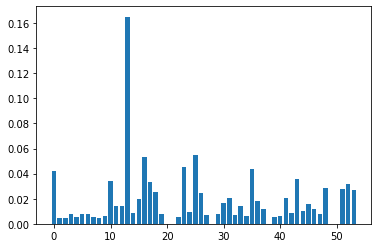

In [84]:
# plot
plt.bar(range(len(xgb0.feature_importances_)), xgb0.feature_importances_)
plt.show()

In [74]:
from xgboost import XGBClassifier
import xgboost as xgb

xgb1 = XGBClassifier(
    objective= 'multi:softprob',
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     nthread=4,
     scale_pos_weight=0,
     seed=27
)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb1, 
 param_grid = param_test1, n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train, y_train,
         verbose=100)



[00:53:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




AttributeError: 'GridSearchCV' object has no attribute 'best_model_'

In [79]:
print( gsearch1.best_params_, gsearch1.best_score_)
gsearch1.cv_results_
# xgb_best = gsearch1.best_model_



{'max_depth': 9, 'min_child_weight': 1} 0.8546872379582366


{'mean_fit_time': array([218.99660392, 245.99979081, 252.31283188, 339.80339932,
        327.429141  , 313.54738097, 429.40087357, 412.39515119,
        385.62885165, 458.26318784, 417.15637321, 332.50431204]),
 'std_fit_time': array([12.84989858,  2.21105454, 10.63074176, 39.72314307,  9.416701  ,
        12.40541032, 14.58954662, 10.36380453,  6.17919731, 18.09574963,
         9.09921281, 44.6689562 ]),
 'mean_score_time': array([0.45915403, 0.53540826, 0.58344541, 1.21937509, 0.74511142,
        0.85834632, 1.06866612, 0.92281408, 1.07349319, 1.09396343,
        0.94680266, 0.73394794]),
 'std_score_time': array([0.01896421, 0.04435075, 0.08323712, 0.4530828 , 0.05505684,
        0.10460864, 0.10393396, 0.14506454, 0.17492372, 0.15850064,
        0.15234842, 0.14098216]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_

In [80]:
y_predict = gsearch1.predict(X_valid)
report = classification_report(y_predict, y_valid)
print(report)

              precision    recall  f1-score   support

           1       0.74      0.75      0.75       632
           2       0.67      0.75      0.71       587
           3       0.83      0.89      0.86       621
           4       0.98      0.94      0.96       673
           5       0.96      0.90      0.93       665
           6       0.89      0.84      0.87       670
           7       0.96      0.94      0.95       688

    accuracy                           0.86      4536
   macro avg       0.86      0.86      0.86      4536
weighted avg       0.87      0.86      0.86      4536



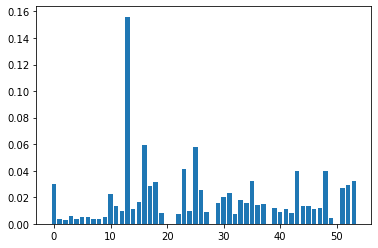

In [82]:
# plot
xgb_best = gsearch1.best_estimator_
plt.bar(range(len(xgb_best.feature_importances_)), xgb_best.feature_importances_)
plt.show()

In [ ]:
# Even thought it is not the best, chosen Max_depth as 3 and min_child weight as 5 to avoid overfit
xgb2 = XGBClassifier(
    objective= 'multi:softprob',
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=3,
     min_child_weight=5,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     nthread=4,
     scale_pos_weight=0,
     seed=27
)

param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = xgb2, 
 param_grid = param_test3, n_jobs=4,iid=False, cv=5)

sresults = gsearch2.fit(X_train, y_train,
         verbose=100)

print(gsearch2.grid_scores_, gsearch3.best_params_, gsearch3.best_score)

xgb_best = gsearch2.best_estimator_
y_predict = xgb_best.predict(X_valid)
report = classification_report(y_predict, y_valid)
print(report)


In [ ]:
xgb_best = gsearch1.best_estimator_
plt.bar(range(len(xgb_best.feature_importances_)), xgb_best.feature_importances_)
plt.show()

Text(0.5, 0, 'Principal Component 1')

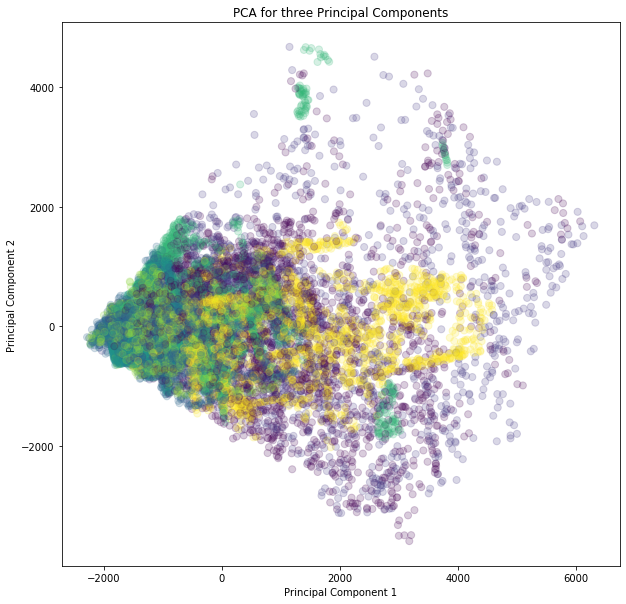

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
train_pca = pca.fit_transform(train_df)

plt.figure(figsize=(10,10))


plt.scatter(train_pca[:,0], train_pca[:,1], c=y, alpha=0.2, s=50)
plt.title('PCA for three Principal Components')
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
  

In [46]:
from xgboost import XGBClassifier
import xgboost as xgb

X_p_train,X_p_test,y_p_train,y_p_test = train_test_split(train_pca, y, test_size=0.2, random_state=123)

xgb0 = XGBClassifier(
    objective= 'multi:softmax',
    random_state=0,
    learning_rat= 0.05,
    max_depth=9,
    n_estimators=500,
    colsample_bytree=0.1,
    subsample=0.8,
    max_delta_step=0.0,
    n_jobs=-1
)

xgb0.fit(X_p_train, y_p_train,
         verbose=100,
#          early_stopping_rounds=3,
         eval_metric=["auc", "logloss"]
        )

y_predict = xgb0.predict(X_p_test)
report = classification_report(y_predict, y_p_test)
print(report)

[20:40:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { learning_rat } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           1       0.45      0.52      0.48       389
           2       0.44      0.40      0.42       418
           3       0.49      0.50      0.50       427
           4       0.76      0.74      0.75       437
           5       0.67      0.65      0.66       476
           6       0.53      0.54      0.53       442
           7       0.75      0.73      0.74       435

    accuracy                           0.59      3024
   macro avg       0.58      0.58      0.58      3024
weighted avg       0.59      0.59      0.59      3024

